In [1]:
from pathlib import Path
from functools import partial

from utils import load_polar

import pybem as pb
import numpy as np
import pandas as pd
import proplot as plot
import sympy as sy

Inputs

How to compute the Aspect Ratio of the blade.

$$
AR = R^2 / S
$$
where $S$ is the blade area, computed like:
$$
S = \int_{R_{min}}^{R} c(r)dr
$$

We are now going to use `sympy` to compute the area numerically for some special cases to validate our simulator. We assume the chord to vary linearly with `r`. 

In [2]:
r, R, R0 = sy.symbols("r, R, R0")
a, b = sy.symbols("a, b")
c, c0 = sy.symbols("c, c0")

Set up a generic linear variation

In [3]:
expr = a + b * r
expr

a + b*r

Create system of equations to determine the coefficients such that they match initial and final values. 

In [4]:
eq1 = sy.Eq(lhs = expr.subs(r, R), rhs = c) # Tip
eq2 = sy.Eq(lhs = expr.subs(r, R0), rhs = c0) # Hub

Solve the system and obtain the coefficients

In [5]:
sol = sy.linsolve([eq1, eq2], (a, b))

a_sol , b_sol = sol.args[0]
print("a =", a_sol)
print("b =", b_sol)

a = (R*c0 - R0*c)/(R - R0)
b = (c - c0)/(R - R0)


Create chord variation equation and integrate to obtain blade area. 

In [6]:
chord = a_sol + b_sol * r

area = sy.factor(sy.integrate(chord, (r, R0, R)))
area

(R - R0)*(c + c0)/2

In [7]:
print(sy.pycode(area))

print(sy.pycode(chord))

(1/2)*(R - R0)*(c + c0)
r*(c - c0)/(R - R0) + (R*c0 - R0*c)/(R - R0)


In [8]:
PATH_POLARS = Path("../polars")
file_lift = "lift.csv"
file_drag = "drag.csv"
file_propeller = PATH_POLARS / "propeller1_inches.txt"

PITCH_RATIO = 0.9
PITCH = 32.4  # inches for diameter of 36 inches

In [9]:
INCH_METER = 0.0254
PITCH = INCH_METER * PITCH  # meters

In [10]:
csv_reader = partial(pd.read_csv, sep=";", index_col=None)
load_polar = partial(
    load_polar,
    path=PATH_POLARS,
    file_lift=file_lift,
    file_drag=file_drag,
    reader=csv_reader,
)

In [11]:
dimensions_original_df = pd.read_csv(filepath_or_buffer=file_propeller, sep=",")

# Enforce stripped columns
dimensions_original_df.columns = [col.strip() for col in dimensions_original_df.columns]
dimensions_original_df = dimensions_original_df[["radius", "chord"]]

# Convert to international units
dimensions_original_df = dimensions_original_df.mul(INCH_METER)

# Name
dimensions_original_df.index = ["Hub", "S1", "S2", "S3", "S4", "Tip"]

Create the blade by defining the sections at each stage.

In [12]:
def generate_sections(coefficient, dimensions_original):
    
    dimensions_df = dimensions_original.copy()
    
    # Scale the propeller size and compute theta
    dimensions_df["chord"] *= coefficient
    
    R = dimensions_df["radius"].max()
    
    # Compute pitch angle distribution
    for idx, row in dimensions_df.iterrows():

        r = row["radius"]

        # Constant pitch law
        tan_theta = (2.0 * PITCH_RATIO * R) / (2.0 * np.pi * r)
        theta = np.arctan(tan_theta)  # radians
        theta = np.rad2deg(theta)  # degrees

        dimensions_df.loc[idx, "theta"] = theta

    # Define sections
    sections = [
        pb.Section(
            name="Hub",
            r=dimensions_df.loc["Hub", "radius"],
            beta=dimensions_df.loc["Hub", "theta"],
            chord=dimensions_df.loc["Hub", "chord"],
            airfoil=pb.Airfoil(
                polar_cl=load_polar(airfoil_type="765", which="cl"),
                polar_cd=load_polar(airfoil_type="765", which="cd"),
            ),
        ),
        pb.Section(
            name="S1",
            r=dimensions_df.loc["S1", "radius"],
            beta=dimensions_df.loc["S1", "theta"],
            chord=dimensions_df.loc["S1", "chord"],
            airfoil=pb.Airfoil(
                polar_cl=load_polar(airfoil_type="765", which="cl"),
                polar_cd=load_polar(airfoil_type="765", which="cd"),
            ),
        ),
        pb.Section(
            name="S2",
            r=dimensions_df.loc["S2", "radius"],
            beta=dimensions_df.loc["S2", "theta"],
            chord=dimensions_df.loc["S2", "chord"],
            airfoil=pb.Airfoil(
                polar_cl=load_polar(airfoil_type="764", which="cl"),
                polar_cd=load_polar(airfoil_type="764", which="cd"),
            ),
        ),
        pb.Section(
            name="S3",
            r=dimensions_df.loc["S3", "radius"],
            beta=dimensions_df.loc["S3", "theta"],
            chord=dimensions_df.loc["S3", "chord"],
            airfoil=pb.Airfoil(
                polar_cl=load_polar(airfoil_type="763", which="cl"),
                polar_cd=load_polar(airfoil_type="763", which="cd"),
            ),
        ),
        pb.Section(
            name="S4",
            r=dimensions_df.loc["S4", "radius"],
            beta=dimensions_df.loc["S4", "theta"],
            chord=dimensions_df.loc["S4", "chord"],
            airfoil=pb.Airfoil(
                polar_cl=load_polar(airfoil_type="762", which="cl"),
                polar_cd=load_polar(airfoil_type="762", which="cd"),
            ),
        ),
        pb.Section(
            name="Tip",
            r=dimensions_df.loc["Tip", "radius"],
            beta=dimensions_df.loc["Tip", "theta"],
            chord=dimensions_df.loc["Tip", "chord"],
            airfoil=pb.Airfoil(
                polar_cl=load_polar(airfoil_type="761", which="cl"),
                polar_cd=load_polar(airfoil_type="761", which="cd"),
            ),
        ),
    ]
    
    return sections

In [16]:
# Define propeller
COEFF_0 = 0.5
COEFF_N = 3
N = 5

results = []
for coeff in np.linspace(start=COEFF_0, stop=COEFF_N, num=N):

    sections = generate_sections(
        coefficient=coeff, dimensions_original=dimensions_original_df
    )

    propeller = pb.Propeller(B=2, sections=sections)

    # Define flow conditions and BEM method

    for J in np.linspace(1e-1, 1.5):

        pi = np.pi

        _lambda = J / pi

        bem = pb.BladeElementMethod(
            _lambda=_lambda, propeller=propeller, tip_loss=True, hub_loss=False
        )

        try:
            # Solve
            bem.solve()
            CT, CQ = bem.integrate_forces()
        except:
            CT = np.nan
            CQ = np.nan

        AR = propeller.aspect_ratio
        
        # Create experiments non-dimensionless coefficients
        results.append(
            (
                AR,
                J,
                CT * (pi ** 3.0) / 4 / J ** 2.0,
                CQ * (pi ** 4.0) / 4 / J ** 2.0,
                _lambda * CT / CQ,  # efficiency
            )
        )

        del bem

    del propeller

results_df = pd.DataFrame(results, columns=["AR", "J", "CT", "CP", "eta"]).dropna()

In [17]:
results_df

,AR,J,CT,CP,eta
12,17.314629,0.442857,0.282554,0.204950,0.610545
13,17.314629,0.471429,0.241452,0.179703,0.633418
14,17.314629,0.500000,0.207440,0.158395,0.654817
15,17.314629,0.528571,0.178951,0.140261,0.674372
16,17.314629,0.557143,0.155154,0.124850,0.692374
...,...,...,...,...,...
225,2.885771,0.814286,0.166354,0.206728,0.655255
226,2.885771,0.842857,0.143503,0.185501,0.652031
227,2.885771,0.871429,0.122904,0.166048,0.645008
228,2.885771,0.900000,0.104567,0.148475,0.633843


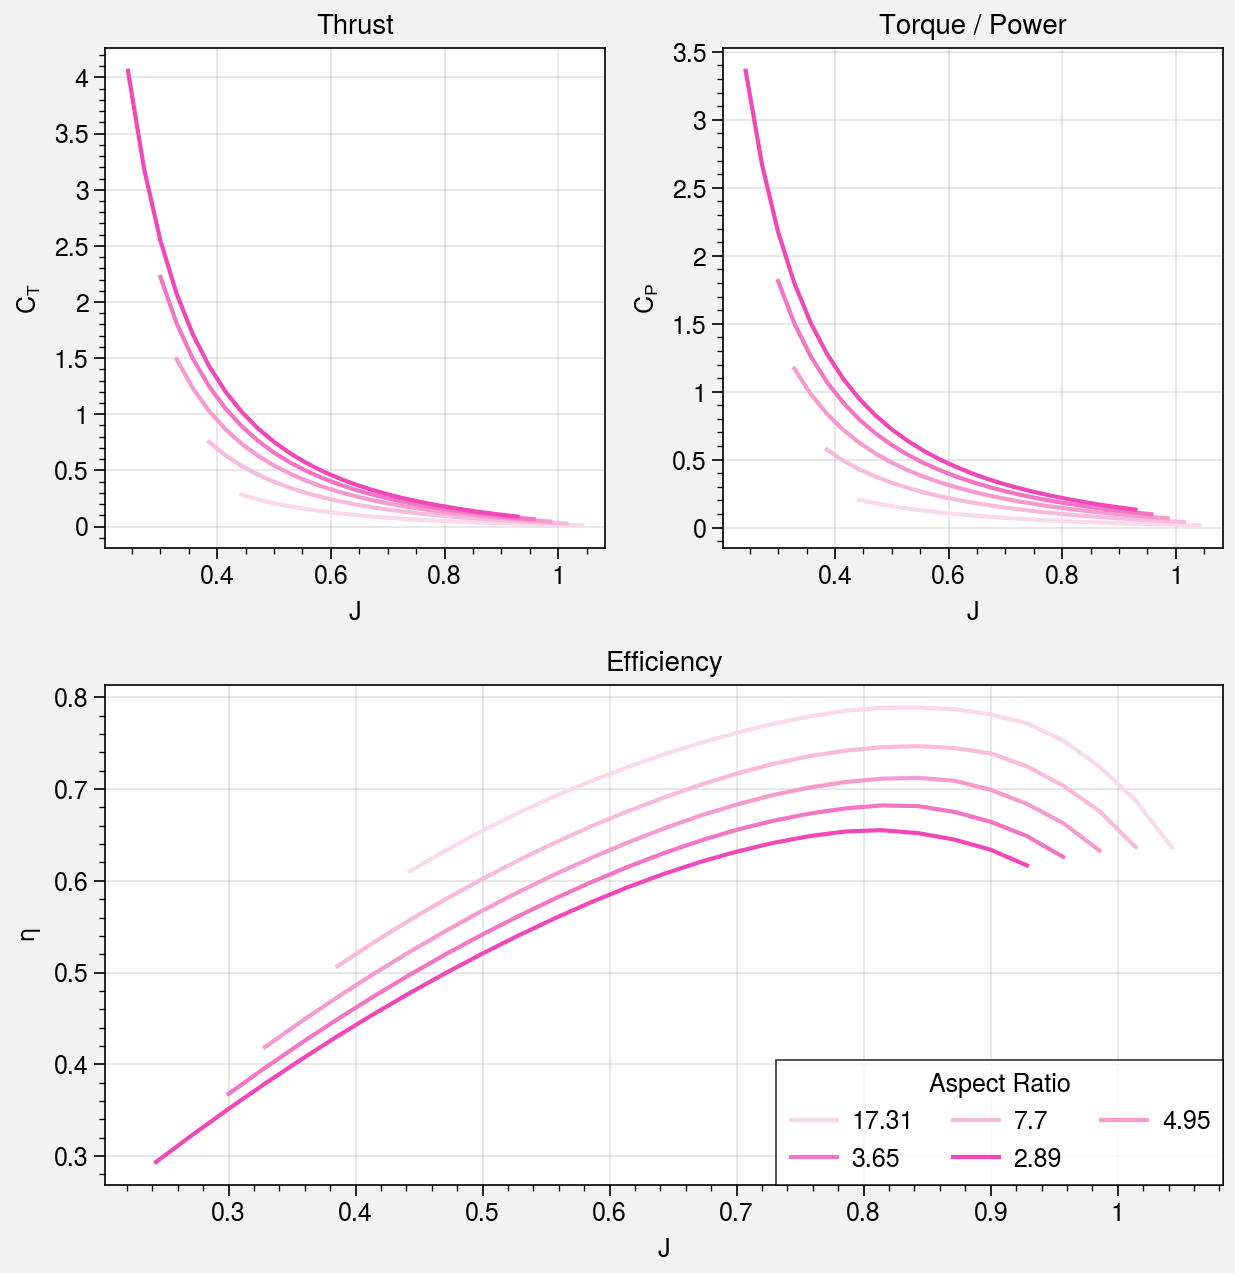

In [18]:
_array = [[1, 2], [3, 3]]
fig, axes = plot.subplots(array=_array, share=0)

Rs = results_df["AR"].unique()
for R in Rs:

    mask = results_df["AR"] == AR
    _results_df = results_df.loc[mask].set_index("J").drop("AR", axis=1)

    name = np.round(AR, 2)
    name = str(name)
    ############
    # Thrust
    ############
    ax = axes[0]
    thrust = _results_df["CT"]
    thrust.name = name
    lines = ax.plot(
        thrust,
        cycle="plum",
    )
    ax.format(
        title="Thrust",
        ylabel="$C_T$",
    )

    ############
    # Torque
    ############
    ax = axes[1]
    torque = _results_df["CP"]
    torque.name = name

    ax.plot(
        torque,
        cycle="plum",
    )
    ax.format(
        title="Torque / Power",
        ylabel="$C_P$",
    )

    ############
    # Efficiency
    ############
    ax = axes[-1]
    eta = _results_df["eta"]
    eta.name = name
    ax.plot(eta, cycle="plum")
    ax.format(title="Efficiency", ylabel="$\eta$")

axes[-1].legend(title="Aspect Ratio")

fig.save("Aspect_Ratio.pdf")